In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import brier_score_loss, roc_auc_score, auc, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

import warnings


warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/loan_data.csv")

# Data Visualization and Preprocessing

In [3]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
df["loan_status"].unique()

array([1, 0])

In [6]:
df.isnull().any()

person_age                        False
person_gender                     False
person_education                  False
person_income                     False
person_emp_exp                    False
person_home_ownership             False
loan_amnt                         False
loan_intent                       False
loan_int_rate                     False
loan_percent_income               False
cb_person_cred_hist_length        False
credit_score                      False
previous_loan_defaults_on_file    False
loan_status                       False
dtype: bool

In [7]:
df["loan_status"].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

Sampling

In [8]:
df = df.groupby('loan_status').sample(frac=0.2, random_state=42)
df["loan_status"].value_counts()

loan_status
0    7000
1    2000
Name: count, dtype: int64

In [9]:
features = df.drop("loan_status", axis = 1)

In [10]:
df = df.reset_index().drop(["index"], axis = 1)
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,28.0,male,Associate,72926.0,2,MORTGAGE,16800.0,DEBTCONSOLIDATION,12.61,0.23,7.0,586,Yes,0
1,23.0,female,Associate,72988.0,0,MORTGAGE,4500.0,MEDICAL,7.40,0.06,3.0,562,Yes,0
2,22.0,male,Associate,78823.0,0,MORTGAGE,4000.0,DEBTCONSOLIDATION,7.14,0.05,4.0,624,Yes,0
3,23.0,male,Bachelor,79971.0,0,RENT,12000.0,VENTURE,11.01,0.15,4.0,671,No,0
4,28.0,female,High School,80906.0,5,RENT,16000.0,VENTURE,12.18,0.20,6.0,642,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,25.0,female,Associate,28155.0,3,RENT,8000.0,HOMEIMPROVEMENT,14.46,0.28,2.0,565,No,1
8996,23.0,male,Bachelor,61103.0,1,RENT,25000.0,VENTURE,9.03,0.41,3.0,687,No,1
8997,27.0,male,Master,48432.0,8,RENT,20223.0,VENTURE,6.83,0.42,8.0,650,No,1
8998,26.0,female,Associate,79163.0,3,RENT,21000.0,DEBTCONSOLIDATION,14.09,0.27,3.0,627,No,1


In [11]:
encoder=LabelEncoder()
for col in df.columns[df.dtypes=='object']:
    df[col]=encoder.fit_transform(df[col])

In [12]:
X_raw = df.drop("loan_status", axis = 1)
y = df["loan_status"]

In [13]:
X = (X_raw - X_raw.mean()) / X_raw.std()

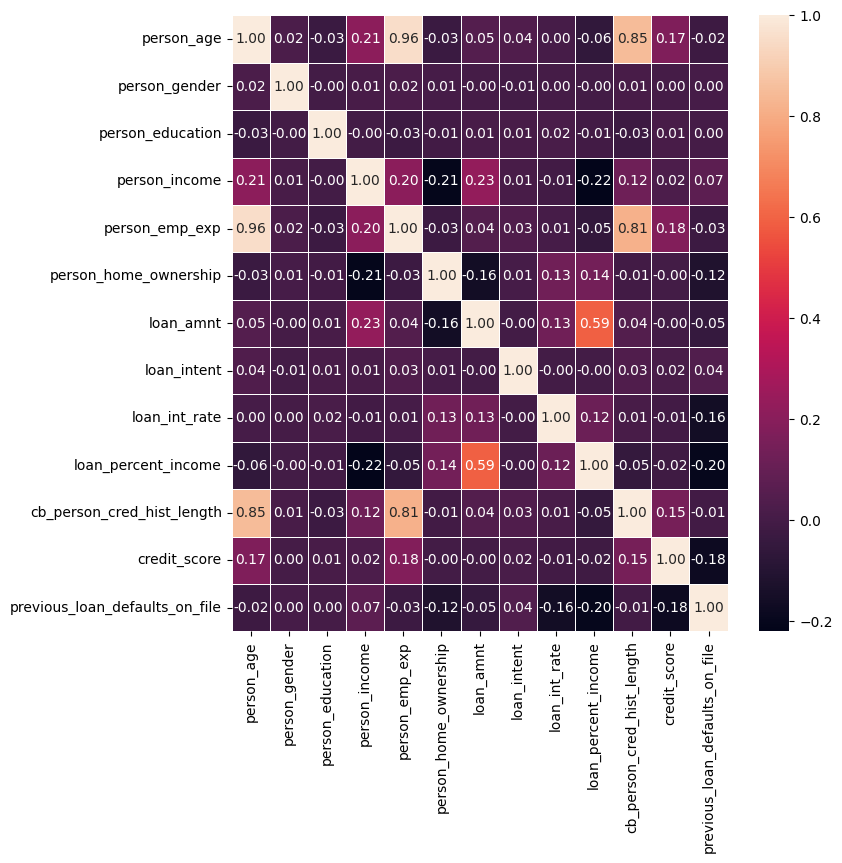

In [14]:
fig, axis = plt.subplots(figsize=(8, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt='.2f', ax=axis)
plt.show()

### Histogram

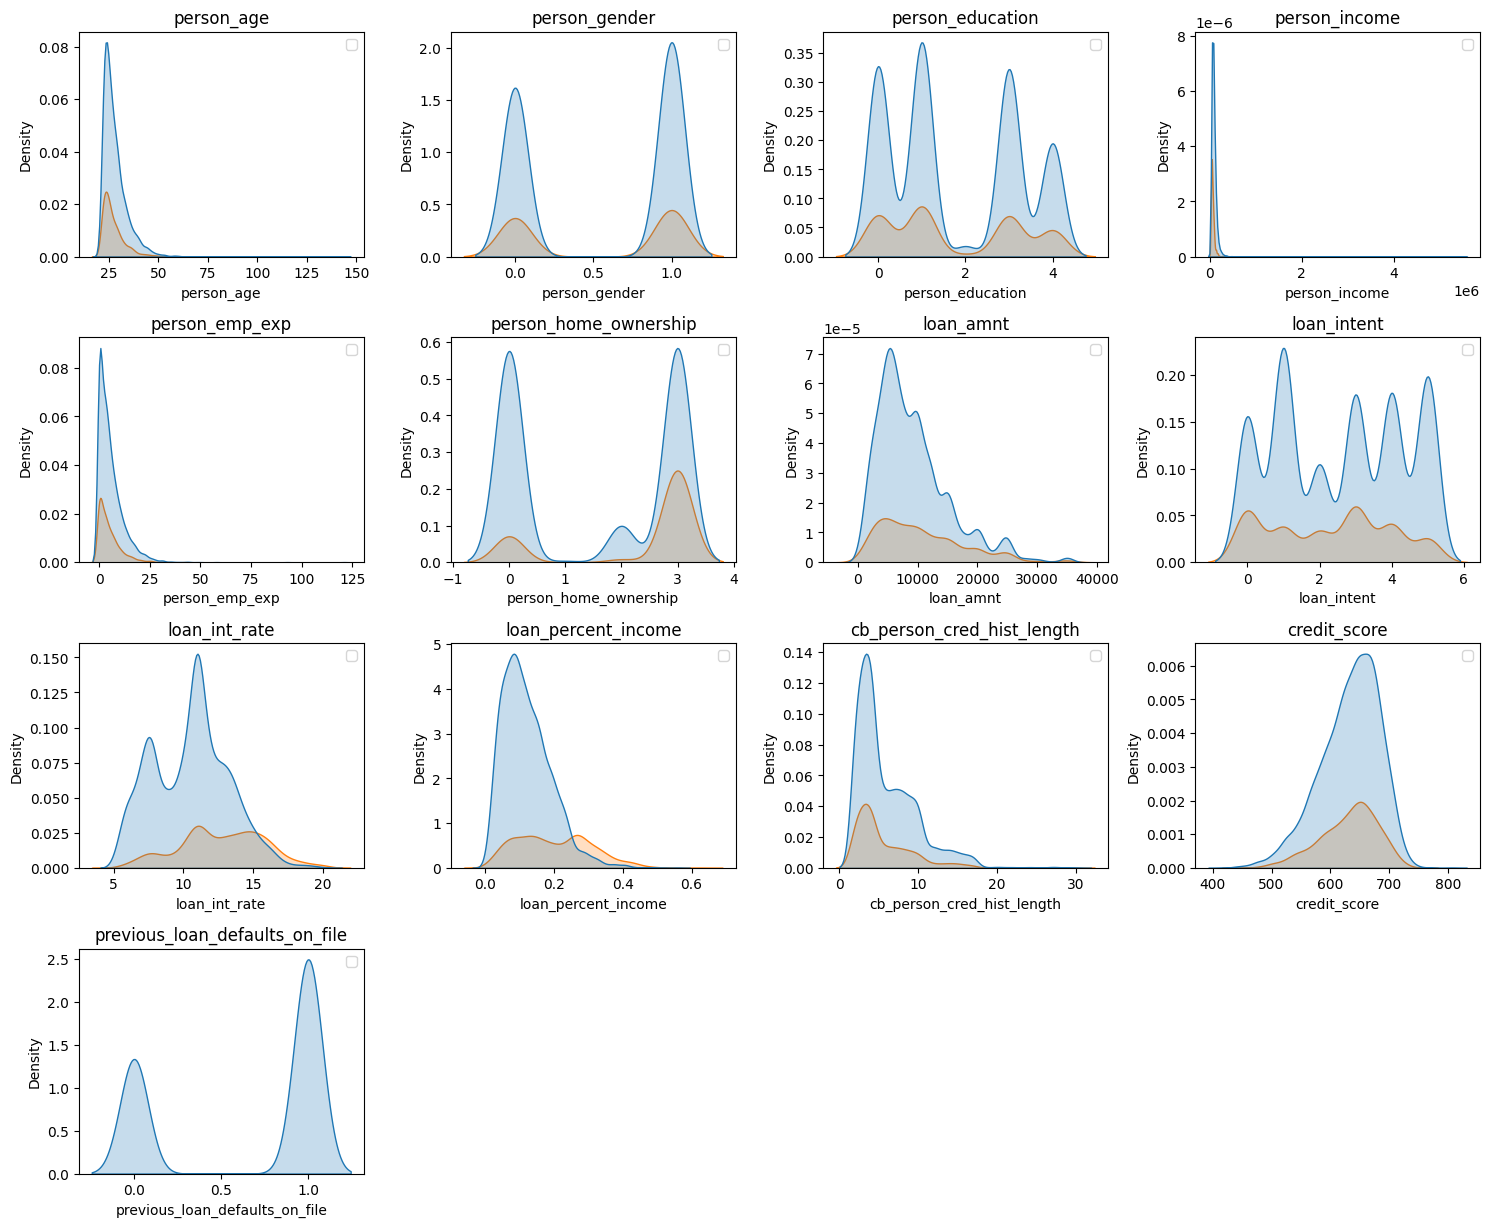

In [15]:
plt.figure(figsize=(15,15))
for ax, col in enumerate(X.columns):

    plt.subplot(5,4, ax+1)
    plt.title(col)
    sns.kdeplot(x=df[col],shade=True, hue=df["loan_status"])
    plt.legend()

plt.tight_layout()

### Density graph of labels.

<Axes: xlabel='loan_status', ylabel='Density'>

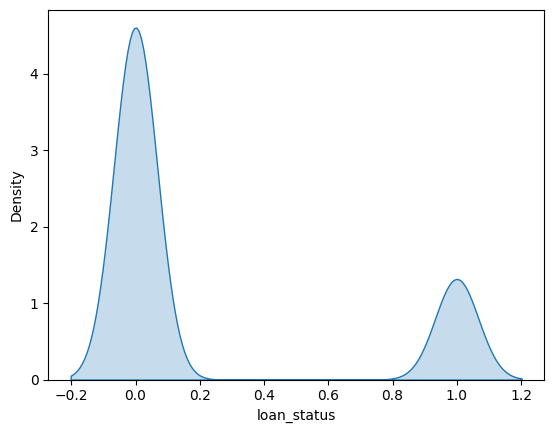

In [16]:
sns.kdeplot(y, shade = True)

## Metrics Calculations

In [17]:
def matrics_cal(y_test, y_pred, y_proba = None):
    matrics = {}
    matrics["TP"] = sum(np.where(y_test & y_pred, 1, 0))
    matrics["TN"] = sum(np.where( (y_test == 0) & (y_pred == 0), 1, 0))
    matrics["FP"] = sum(np.where( (y_test == 0) & (y_pred == 1), 1, 0))
    matrics["FN"] = sum(np.where( (y_test == 1) & (y_pred == 0), 1, 0))

    matrics["TPR"] =  round(matrics["TP"] / (matrics["TP"] +  matrics["FN"]),3)
    matrics["TNR"] =  round(matrics["TN"] / (matrics["TN"] +  matrics["FP"]),3)
    matrics["FPR"] =  round(matrics["FP"] / (matrics["FP"] +  matrics["TN"]),3)
    matrics["FNR"] =  round(matrics["FN"] / (matrics["TP"] +  matrics["FN"]),3)

    matrics["Accuracy"] = round((matrics["TP"] + matrics["TN"]) / (matrics["TP"] + matrics["TN"] + matrics["FP"] + matrics["FN"]),3)
    matrics["Precision"] = round(matrics["TP"] / (matrics["TP"] +  matrics["FP"]),3)
    matrics["F1"] = 2 * round(((matrics["Precision"] * matrics["TPR"]) / (matrics["Precision"] + matrics["TPR"])),3)

    matrics["brier_score"] = round(brier_score_loss(y_test, y_proba),3)
    matrics["AUC"] =  round(roc_auc_score(y_test, y_proba),3)
    reference_prob = np.mean(y_test)
    reference_brier_score = brier_score_loss(y_test, [reference_prob] * len(y_test))
    matrics["BSS"] = round(1 - (matrics["brier_score"] / reference_brier_score),3)
		
    return matrics

## Common training function

In [18]:
def train(clf, X, y):
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    metrics_list = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
        # Splitting the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        clf.fit(X_train, y_train)
    
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        
        mat = matrics_cal(y_test, y_pred, y_pred_proba)
        print(f"Fold {i}: {mat}")
       
        metrics_list.append(mat)

    return metrics_list, y_pred_proba

In [19]:
def plot_matrics(matrics):
    plt.figure(figsize=(15,15))
    for ax, col in enumerate(matrics.columns):
        plt.subplot(5,4, ax+1)
        plt.title(col)
        sns.lineplot(data=matrics, x=matrics.index, y=col)
        plt.xlabel("Folds")
        plt.legend()
    
    plt.tight_layout()

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [21]:
rnf_matrics, rnf_pred_proba = train(clf, X, y)

Fold 1: {'TP': np.int64(146), 'TN': np.int64(680), 'FP': np.int64(21), 'FN': np.int64(53), 'TPR': np.float64(0.734), 'TNR': np.float64(0.97), 'FPR': np.float64(0.03), 'FNR': np.float64(0.266), 'Accuracy': np.float64(0.918), 'Precision': np.float64(0.874), 'F1': np.float64(0.798), 'brier_score': np.float64(0.059), 'AUC': np.float64(0.967), 'BSS': np.float64(0.657)}
Fold 2: {'TP': np.int64(153), 'TN': np.int64(661), 'FP': np.int64(33), 'FN': np.int64(53), 'TPR': np.float64(0.743), 'TNR': np.float64(0.952), 'FPR': np.float64(0.048), 'FNR': np.float64(0.257), 'Accuracy': np.float64(0.904), 'Precision': np.float64(0.823), 'F1': np.float64(0.78), 'brier_score': np.float64(0.063), 'AUC': np.float64(0.963), 'BSS': np.float64(0.643)}
Fold 3: {'TP': np.int64(136), 'TN': np.int64(687), 'FP': np.int64(27), 'FN': np.int64(50), 'TPR': np.float64(0.731), 'TNR': np.float64(0.962), 'FPR': np.float64(0.038), 'FNR': np.float64(0.269), 'Accuracy': np.float64(0.914), 'Precision': np.float64(0.834), 'F1': n

In [22]:
rnf_matrics = pd.DataFrame(rnf_matrics)
rnf_matrics

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Accuracy,Precision,F1,brier_score,AUC,BSS
0,146,680,21,53,0.734,0.970,0.030,0.266,0.918,0.874,0.798,0.059,0.967,0.657
1,153,661,33,53,0.743,0.952,0.048,0.257,0.904,0.823,0.780,0.063,0.963,0.643
2,136,687,27,50,0.731,0.962,0.038,0.269,0.914,0.834,0.780,0.063,0.959,0.616
3,131,698,29,42,0.757,0.960,0.040,0.243,0.921,0.819,0.786,0.058,0.965,0.626
4,141,671,26,62,0.695,0.963,0.037,0.305,0.902,0.844,0.762,0.065,0.963,0.628
5,138,680,23,59,0.701,0.967,0.033,0.299,0.909,0.857,0.772,0.063,0.965,0.632
6,143,676,15,66,0.684,0.978,0.022,0.316,0.910,0.905,0.780,0.061,0.966,0.658
7,160,659,25,56,0.741,0.963,0.037,0.259,0.910,0.865,0.798,0.062,0.967,0.660
8,151,670,27,52,0.744,0.961,0.039,0.256,0.912,0.848,0.792,0.061,0.966,0.651
9,160,667,25,48,0.769,0.964,0.036,0.231,0.919,0.865,0.814,0.059,0.969,0.668


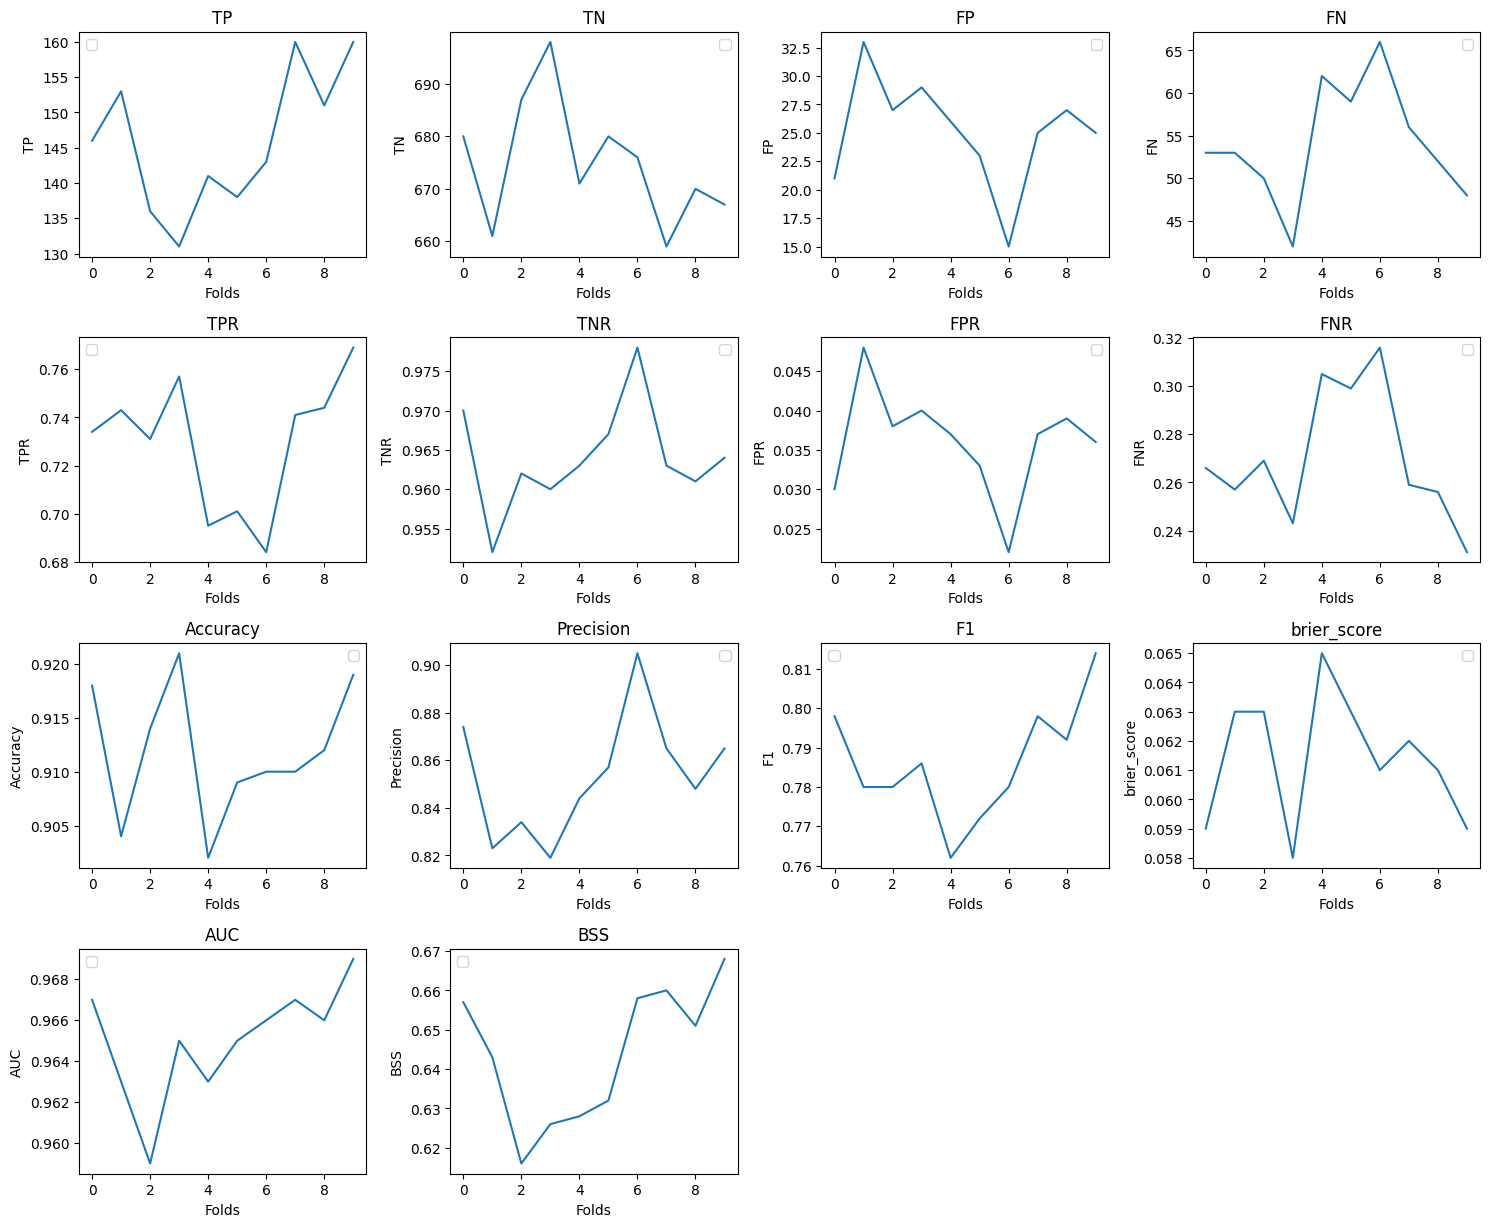

In [23]:
plot_matrics(rnf_matrics)

In [24]:
avg_rnf_matrics = rnf_matrics.mean()

Naive Bayes

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn_matrics, knn_pred_proba = train(knn, X, y)

Fold 1: {'TP': np.int64(139), 'TN': np.int64(652), 'FP': np.int64(49), 'FN': np.int64(60), 'TPR': np.float64(0.698), 'TNR': np.float64(0.93), 'FPR': np.float64(0.07), 'FNR': np.float64(0.302), 'Accuracy': np.float64(0.879), 'Precision': np.float64(0.739), 'F1': np.float64(0.718), 'brier_score': np.float64(0.096), 'AUC': np.float64(0.877), 'BSS': np.float64(0.443)}
Fold 2: {'TP': np.int64(155), 'TN': np.int64(642), 'FP': np.int64(52), 'FN': np.int64(51), 'TPR': np.float64(0.752), 'TNR': np.float64(0.925), 'FPR': np.float64(0.075), 'FNR': np.float64(0.248), 'Accuracy': np.float64(0.886), 'Precision': np.float64(0.749), 'F1': np.float64(0.75), 'brier_score': np.float64(0.094), 'AUC': np.float64(0.891), 'BSS': np.float64(0.467)}
Fold 3: {'TP': np.int64(123), 'TN': np.int64(653), 'FP': np.int64(61), 'FN': np.int64(63), 'TPR': np.float64(0.661), 'TNR': np.float64(0.915), 'FPR': np.float64(0.085), 'FNR': np.float64(0.339), 'Accuracy': np.float64(0.862), 'Precision': np.float64(0.668), 'F1': n

In [26]:
knn_matrics = pd.DataFrame(knn_matrics)
knn_matrics

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Accuracy,Precision,F1,brier_score,AUC,BSS
0,139,652,49,60,0.698,0.930,0.070,0.302,0.879,0.739,0.718,0.096,0.877,0.443
1,155,642,52,51,0.752,0.925,0.075,0.248,0.886,0.749,0.750,0.094,0.891,0.467
2,123,653,61,63,0.661,0.915,0.085,0.339,0.862,0.668,0.664,0.099,0.883,0.396
3,115,667,60,58,0.665,0.917,0.083,0.335,0.869,0.657,0.660,0.101,0.877,0.350
4,129,643,54,74,0.635,0.923,0.077,0.365,0.858,0.705,0.668,0.107,0.869,0.387
5,125,646,57,72,0.635,0.919,0.081,0.365,0.857,0.687,0.660,0.101,0.879,0.409
6,136,659,32,73,0.651,0.954,0.046,0.349,0.883,0.810,0.722,0.087,0.903,0.512
7,149,622,62,67,0.690,0.909,0.091,0.310,0.857,0.706,0.698,0.107,0.876,0.413
8,132,653,44,71,0.650,0.937,0.063,0.350,0.872,0.750,0.696,0.094,0.893,0.462
9,141,637,55,67,0.678,0.921,0.079,0.322,0.864,0.719,0.698,0.095,0.899,0.465


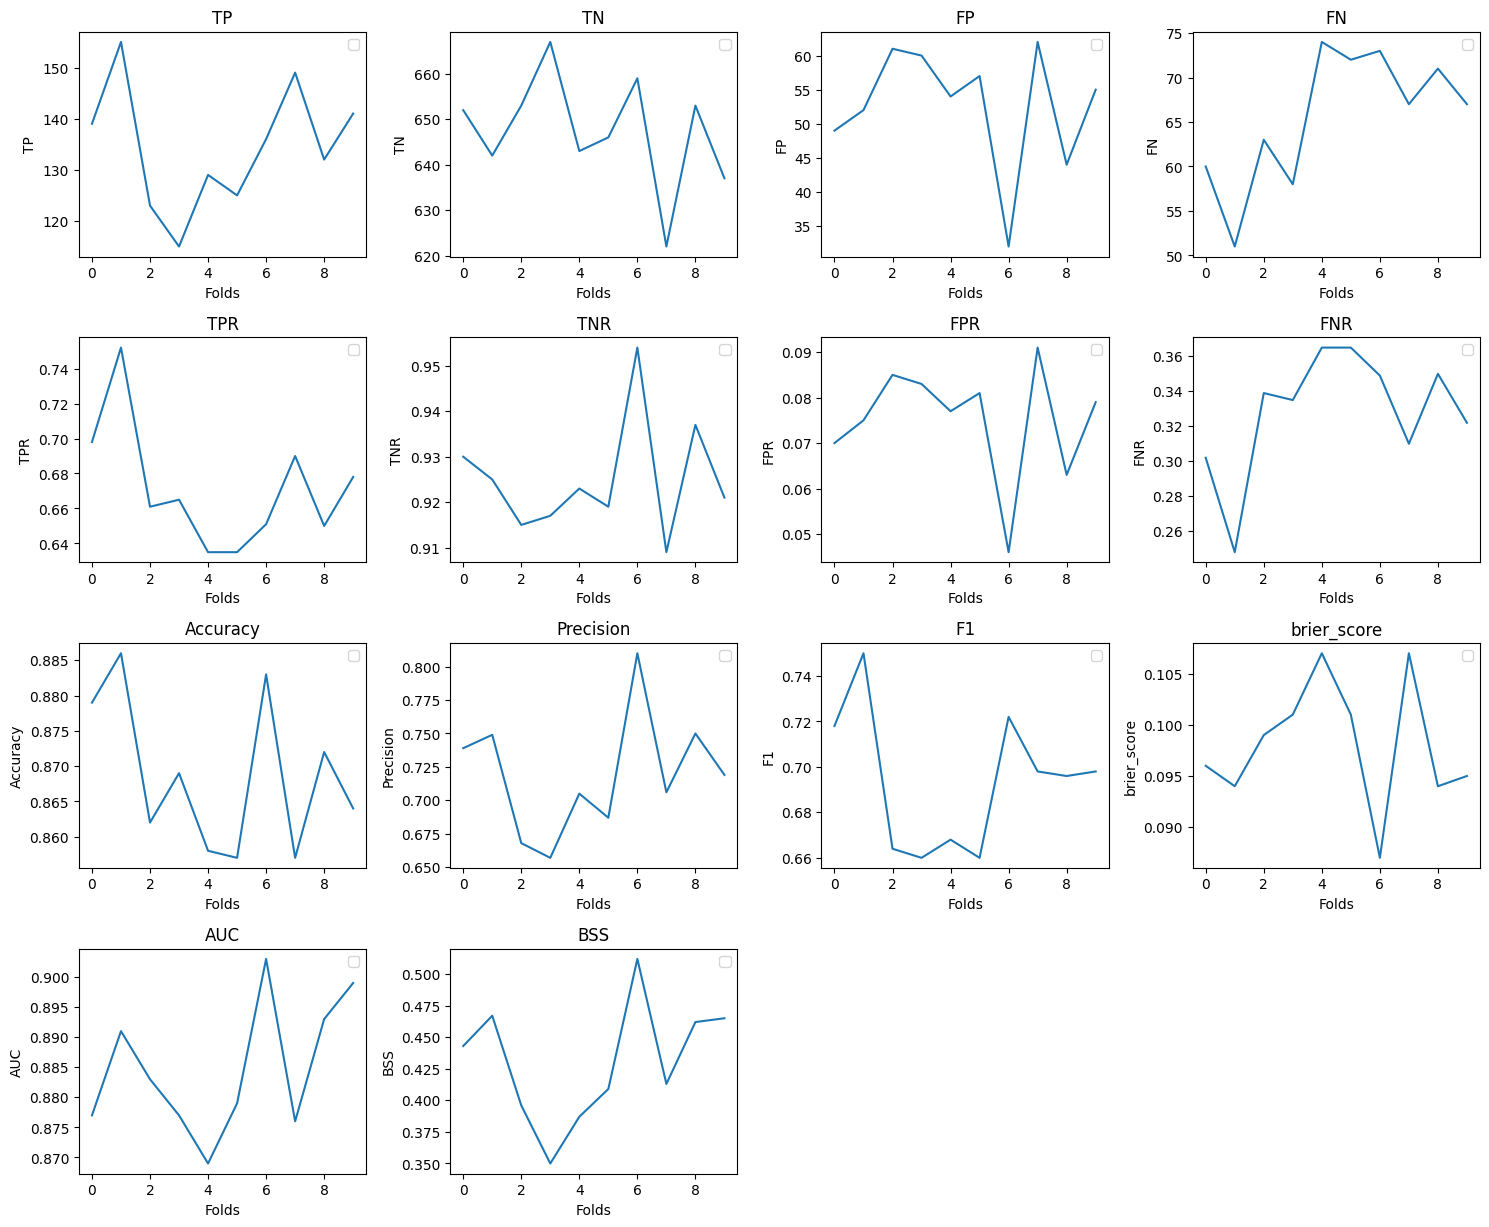

In [27]:
plot_matrics(knn_matrics)

## LSTM

In [28]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64,activation='relu', input_shape=(X.shape[1], 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Change based on your task
model.compile(optimizer=Adam(), loss='mean_squared_error')


kf = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_list = []

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
	# Splitting the data
	X_train, X_test = X.iloc[train_index], X.iloc[test_index]
	y_train, y_test = y.iloc[train_index], y.iloc[test_index]

	model.fit(X_train, y_train, validation_data=(X_test, y_test))

	lstm_pred_proba = model.predict(X_test)
	pred_labels = lstm_pred_proba > 0.5
	y_pred = pred_labels.astype(int).reshape(-1)

	mat = matrics_cal(y_test, y_pred, lstm_pred_proba)
	print(f"Fold {i}: {mat}")

	metrics_list.append(mat)

lstm_metrics = pd.DataFrame(metrics_list)
lstm_metrics
    

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1770 - val_loss: 0.1037
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 1: {'TP': np.int64(101), 'TN': np.int64(667), 'FP': np.int64(34), 'FN': np.int64(98), 'TPR': np.float64(0.508), 'TNR': np.float64(0.951), 'FPR': np.float64(0.049), 'FNR': np.float64(0.492), 'Accuracy': np.float64(0.853), 'Precision': np.float64(0.748), 'F1': np.float64(0.606), 'brier_score': np.float64(0.104), 'AUC': np.float64(0.918), 'BSS': np.float64(0.396)}
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1038 - val_loss: 0.0950
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2: {'TP': np.int64(137), 'TN': np.int64(652), 'FP': np.int64(42), 'FN': np.int64(69), 'TPR': np.float64(0.665), 'TNR': np.float64(0.939), 'FPR': np.float64(0.061), 'FNR': np.float64(0.335), 'Accuracy': np.float64(0.877), 'Precision': np.float64(0.765), 'F1': np.float64(0.712), 'brier_score': np.float64(0.095), 'AUC': np.float64(0.923), 'BSS': np.float64(0.462)}
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Accuracy,Precision,F1,brier_score,AUC,BSS
0,101,667,34,98,0.508,0.951,0.049,0.492,0.853,0.748,0.606,0.104,0.918,0.396
1,137,652,42,69,0.665,0.939,0.061,0.335,0.877,0.765,0.712,0.095,0.923,0.462
2,139,632,82,47,0.747,0.885,0.115,0.253,0.857,0.629,0.682,0.097,0.922,0.408
3,119,674,53,54,0.688,0.927,0.073,0.312,0.881,0.692,0.690,0.082,0.933,0.472
4,121,649,48,82,0.596,0.931,0.069,0.404,0.856,0.716,0.650,0.100,0.910,0.428
5,135,669,34,62,0.685,0.952,0.048,0.315,0.893,0.799,0.738,0.076,0.945,0.555
6,139,664,27,70,0.665,0.961,0.039,0.335,0.892,0.837,0.742,0.077,0.947,0.568
7,158,634,50,58,0.731,0.927,0.073,0.269,0.880,0.760,0.746,0.085,0.940,0.534
8,118,677,20,85,0.581,0.971,0.029,0.419,0.883,0.855,0.692,0.080,0.950,0.542
9,151,659,33,57,0.726,0.952,0.048,0.274,0.900,0.821,0.770,0.072,0.956,0.595


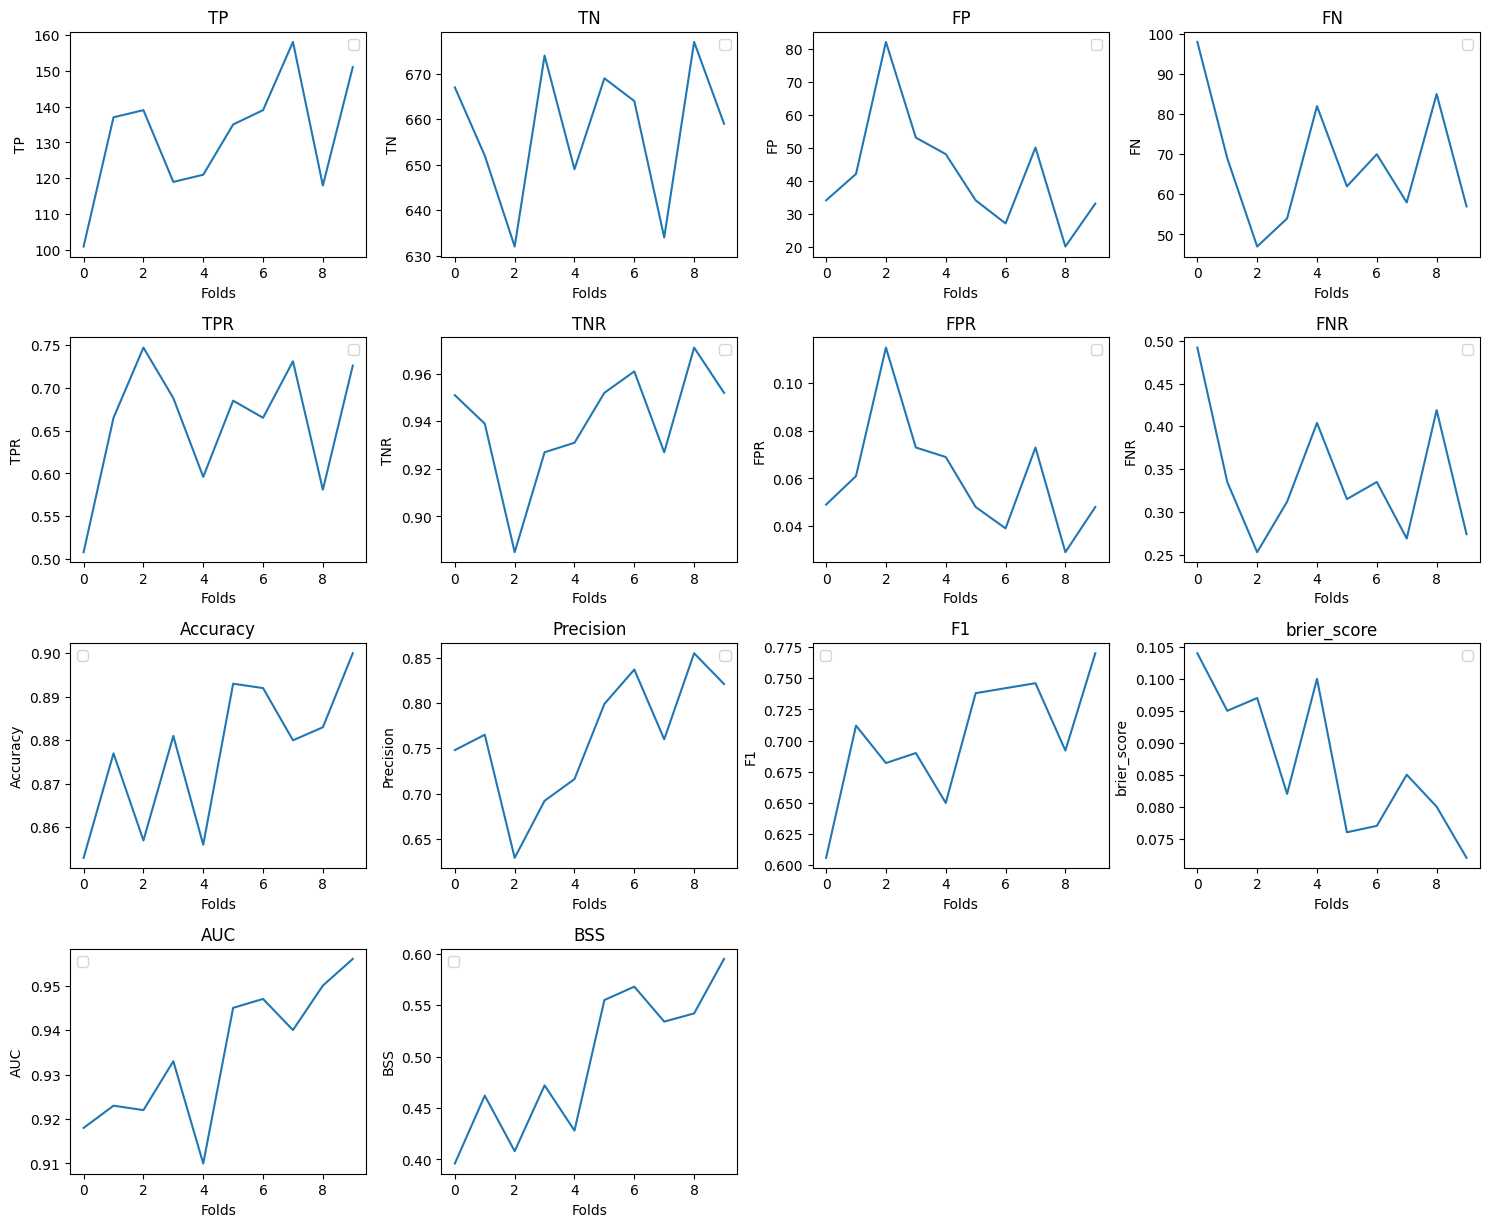

In [29]:
plot_matrics(lstm_metrics)

# Metrics Comparison

In [30]:
rnf_matrics

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Accuracy,Precision,F1,brier_score,AUC,BSS
0,146,680,21,53,0.734,0.970,0.030,0.266,0.918,0.874,0.798,0.059,0.967,0.657
1,153,661,33,53,0.743,0.952,0.048,0.257,0.904,0.823,0.780,0.063,0.963,0.643
2,136,687,27,50,0.731,0.962,0.038,0.269,0.914,0.834,0.780,0.063,0.959,0.616
3,131,698,29,42,0.757,0.960,0.040,0.243,0.921,0.819,0.786,0.058,0.965,0.626
4,141,671,26,62,0.695,0.963,0.037,0.305,0.902,0.844,0.762,0.065,0.963,0.628
5,138,680,23,59,0.701,0.967,0.033,0.299,0.909,0.857,0.772,0.063,0.965,0.632
6,143,676,15,66,0.684,0.978,0.022,0.316,0.910,0.905,0.780,0.061,0.966,0.658
7,160,659,25,56,0.741,0.963,0.037,0.259,0.910,0.865,0.798,0.062,0.967,0.660
8,151,670,27,52,0.744,0.961,0.039,0.256,0.912,0.848,0.792,0.061,0.966,0.651
9,160,667,25,48,0.769,0.964,0.036,0.231,0.919,0.865,0.814,0.059,0.969,0.668


In [31]:
knn_matrics

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Accuracy,Precision,F1,brier_score,AUC,BSS
0,139,652,49,60,0.698,0.930,0.070,0.302,0.879,0.739,0.718,0.096,0.877,0.443
1,155,642,52,51,0.752,0.925,0.075,0.248,0.886,0.749,0.750,0.094,0.891,0.467
2,123,653,61,63,0.661,0.915,0.085,0.339,0.862,0.668,0.664,0.099,0.883,0.396
3,115,667,60,58,0.665,0.917,0.083,0.335,0.869,0.657,0.660,0.101,0.877,0.350
4,129,643,54,74,0.635,0.923,0.077,0.365,0.858,0.705,0.668,0.107,0.869,0.387
5,125,646,57,72,0.635,0.919,0.081,0.365,0.857,0.687,0.660,0.101,0.879,0.409
6,136,659,32,73,0.651,0.954,0.046,0.349,0.883,0.810,0.722,0.087,0.903,0.512
7,149,622,62,67,0.690,0.909,0.091,0.310,0.857,0.706,0.698,0.107,0.876,0.413
8,132,653,44,71,0.650,0.937,0.063,0.350,0.872,0.750,0.696,0.094,0.893,0.462
9,141,637,55,67,0.678,0.921,0.079,0.322,0.864,0.719,0.698,0.095,0.899,0.465


In [32]:
lstm_metrics

,TP,TN,FP,FN,TPR,TNR,FPR,FNR,Accuracy,Precision,F1,brier_score,AUC,BSS
0,101,667,34,98,0.508,0.951,0.049,0.492,0.853,0.748,0.606,0.104,0.918,0.396
1,137,652,42,69,0.665,0.939,0.061,0.335,0.877,0.765,0.712,0.095,0.923,0.462
2,139,632,82,47,0.747,0.885,0.115,0.253,0.857,0.629,0.682,0.097,0.922,0.408
3,119,674,53,54,0.688,0.927,0.073,0.312,0.881,0.692,0.690,0.082,0.933,0.472
4,121,649,48,82,0.596,0.931,0.069,0.404,0.856,0.716,0.650,0.100,0.910,0.428
5,135,669,34,62,0.685,0.952,0.048,0.315,0.893,0.799,0.738,0.076,0.945,0.555
6,139,664,27,70,0.665,0.961,0.039,0.335,0.892,0.837,0.742,0.077,0.947,0.568
7,158,634,50,58,0.731,0.927,0.073,0.269,0.880,0.760,0.746,0.085,0.940,0.534
8,118,677,20,85,0.581,0.971,0.029,0.419,0.883,0.855,0.692,0.080,0.950,0.542
9,151,659,33,57,0.726,0.952,0.048,0.274,0.900,0.821,0.770,0.072,0.956,0.595


### Average Comparison

In [33]:
pd.concat([rnf_matrics.mean() , knn_matrics.mean(), lstm_metrics.mean()], axis = 1).rename(columns = {0: "Random Forest", 1: "KNN", 2: "LSTM"})

,Random Forest,KNN,LSTM
TP,145.9000,134.4000,131.8000
TN,674.9000,647.4000,657.7000
FP,25.1000,52.6000,42.3000
FN,54.1000,65.6000,68.2000
TPR,0.7299,0.6715,0.6592
TNR,0.9640,0.9250,0.9396
FPR,0.0360,0.0750,0.0604
FNR,0.2701,0.3285,0.3408
Accuracy,0.9119,0.8687,0.8772
Precision,0.8534,0.7190,0.7622


### Fold wise comparison

In [34]:
for i in range(10):
    print(f"Fold {i+1}:")
    display(pd.DataFrame([rnf_matrics.iloc[i] , knn_matrics.iloc[i], lstm_metrics.iloc[i]]).reset_index().drop("index", axis = 1).T.rename(columns = {0: "Random Forest", 1: "KNN", 2: "LSTM"}))

Fold 1:


,Random Forest,KNN,LSTM
TP,146.000,139.000,101.000
TN,680.000,652.000,667.000
FP,21.000,49.000,34.000
FN,53.000,60.000,98.000
TPR,0.734,0.698,0.508
TNR,0.970,0.930,0.951
FPR,0.030,0.070,0.049
FNR,0.266,0.302,0.492
Accuracy,0.918,0.879,0.853
Precision,0.874,0.739,0.748


Fold 2:


,Random Forest,KNN,LSTM
TP,153.000,155.000,137.000
TN,661.000,642.000,652.000
FP,33.000,52.000,42.000
FN,53.000,51.000,69.000
TPR,0.743,0.752,0.665
TNR,0.952,0.925,0.939
FPR,0.048,0.075,0.061
FNR,0.257,0.248,0.335
Accuracy,0.904,0.886,0.877
Precision,0.823,0.749,0.765


Fold 3:


,Random Forest,KNN,LSTM
TP,136.000,123.000,139.000
TN,687.000,653.000,632.000
FP,27.000,61.000,82.000
FN,50.000,63.000,47.000
TPR,0.731,0.661,0.747
TNR,0.962,0.915,0.885
FPR,0.038,0.085,0.115
FNR,0.269,0.339,0.253
Accuracy,0.914,0.862,0.857
Precision,0.834,0.668,0.629


Fold 4:


,Random Forest,KNN,LSTM
TP,131.000,115.000,119.000
TN,698.000,667.000,674.000
FP,29.000,60.000,53.000
FN,42.000,58.000,54.000
TPR,0.757,0.665,0.688
TNR,0.960,0.917,0.927
FPR,0.040,0.083,0.073
FNR,0.243,0.335,0.312
Accuracy,0.921,0.869,0.881
Precision,0.819,0.657,0.692


Fold 5:


,Random Forest,KNN,LSTM
TP,141.000,129.000,121.000
TN,671.000,643.000,649.000
FP,26.000,54.000,48.000
FN,62.000,74.000,82.000
TPR,0.695,0.635,0.596
TNR,0.963,0.923,0.931
FPR,0.037,0.077,0.069
FNR,0.305,0.365,0.404
Accuracy,0.902,0.858,0.856
Precision,0.844,0.705,0.716


Fold 6:


,Random Forest,KNN,LSTM
TP,138.000,125.000,135.000
TN,680.000,646.000,669.000
FP,23.000,57.000,34.000
FN,59.000,72.000,62.000
TPR,0.701,0.635,0.685
TNR,0.967,0.919,0.952
FPR,0.033,0.081,0.048
FNR,0.299,0.365,0.315
Accuracy,0.909,0.857,0.893
Precision,0.857,0.687,0.799


Fold 7:


,Random Forest,KNN,LSTM
TP,143.000,136.000,139.000
TN,676.000,659.000,664.000
FP,15.000,32.000,27.000
FN,66.000,73.000,70.000
TPR,0.684,0.651,0.665
TNR,0.978,0.954,0.961
FPR,0.022,0.046,0.039
FNR,0.316,0.349,0.335
Accuracy,0.910,0.883,0.892
Precision,0.905,0.810,0.837


Fold 8:


,Random Forest,KNN,LSTM
TP,160.000,149.000,158.000
TN,659.000,622.000,634.000
FP,25.000,62.000,50.000
FN,56.000,67.000,58.000
TPR,0.741,0.690,0.731
TNR,0.963,0.909,0.927
FPR,0.037,0.091,0.073
FNR,0.259,0.310,0.269
Accuracy,0.910,0.857,0.880
Precision,0.865,0.706,0.760


Fold 9:


,Random Forest,KNN,LSTM
TP,151.000,132.000,118.000
TN,670.000,653.000,677.000
FP,27.000,44.000,20.000
FN,52.000,71.000,85.000
TPR,0.744,0.650,0.581
TNR,0.961,0.937,0.971
FPR,0.039,0.063,0.029
FNR,0.256,0.350,0.419
Accuracy,0.912,0.872,0.883
Precision,0.848,0.750,0.855


Fold 10:


,Random Forest,KNN,LSTM
TP,160.000,141.000,151.000
TN,667.000,637.000,659.000
FP,25.000,55.000,33.000
FN,48.000,67.000,57.000
TPR,0.769,0.678,0.726
TNR,0.964,0.921,0.952
FPR,0.036,0.079,0.048
FNR,0.231,0.322,0.274
Accuracy,0.919,0.864,0.900
Precision,0.865,0.719,0.821


### ROC curves

In [35]:
def plot_roc_curve(y_test, pred_proba):
	fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
	roc_auc = auc(fpr, tpr)

	# Plot the ROC curve
	plt.figure()
	plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver Operating Characteristic')
	plt.legend(loc='lower right')
	plt.show()



Random Forest

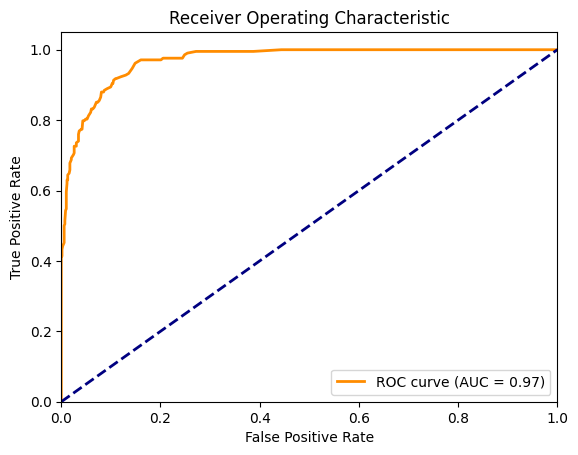

In [36]:
plot_roc_curve(y_test, rnf_pred_proba)

KNN

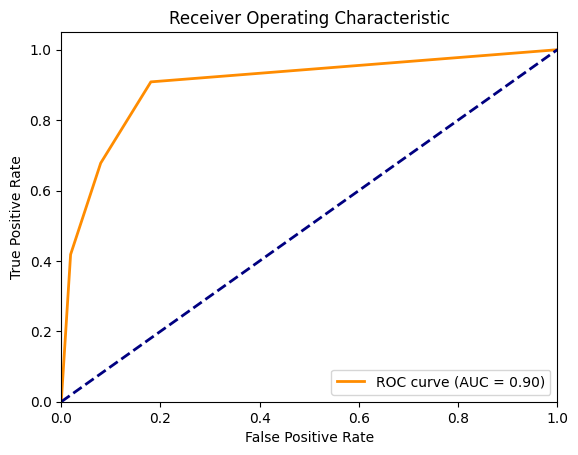

In [37]:
plot_roc_curve(y_test, knn_pred_proba)

LSTM 

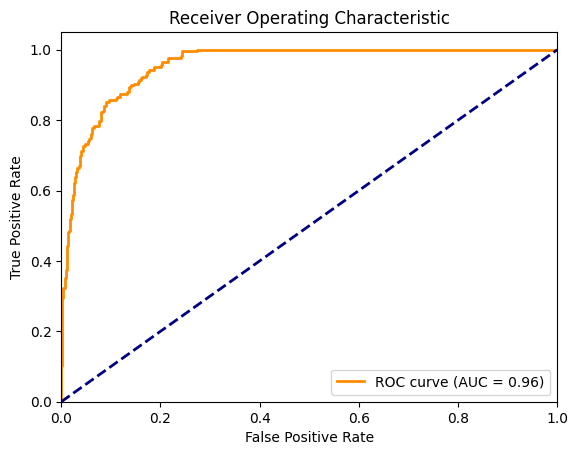

In [38]:
plot_roc_curve(y_test, lstm_pred_proba)